# DFA robustness simulations

Dominik Krzemiński

In [27]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.signal as ss
import scipy.stats as st

plt.style.use('ggplot')
%matplotlib inline

Detrended Fluctuation Analysis is a method which allows to measure self-affinity properties of time series. It is claimed to be very roboust method for Hurst exponent estimation even for nonstationary signals. It consists of three main steps:

1) Cumulative sum calculation;

2) Detrending time series in windows $\Delta n$ equally distributed on logarithmic scale;

3) Mean squared residuals $F$ calculation on a set of windows $\Delta n_i$;

Finally, to determine DFA exponent one need to fit a line to so-called fluctuation function $F(\Delta n)$. A slope of the line is our Hurst exponent estimator.

In the following simulations we test robustness of the method to short and high amplitude artifacs and signal slicing. We use self-implemented version of DFA algorithm, which may be slower but for testing reasons is more transparent and thus easier to understand.

In [28]:
def calc_rms(x, scale):
    """
    Root Mean Square in windows with linear detrending.
    
    Args:
    -----
      *x* : numpy.array
        one dimensional data vector
      *scale* : int
        length of the window in which RMS will be calculaed
    Returns:
    --------
      *rms* : numpy.array
        RMS data in each window with length len(x)//scale
    """
    # making an array with data divided in windows
    shape = (x.shape[0]//scale, scale)
    X = np.lib.stride_tricks.as_strided(x,shape=shape)
    # vector of x-axis points to regression
    scale_ax = np.arange(scale)
    rms = np.zeros(X.shape[0])
    for e, xcut in enumerate(X):
        coeff = np.polyfit(scale_ax, xcut, 1)
        xfit = np.polyval(coeff, scale_ax)
        # detrending and computing RMS of each window
        rms[e] = np.sqrt(np.mean((xcut-xfit)**2))
    return rms

def dfa(x, scale_lim=[5,9], scale_dens=0.25, show=False):
    """
    Detrended Fluctuation Analysis - algorithm with measures power law
    scaling of the given signal *x*.
    More details about algorithm can be found e.g. here:
    Hardstone, R. et al. Detrended fluctuation analysis: A scale-free 
    view on neuronal oscillations, (2012).
    
    Args:
    -----
      *x* : numpy.array
        one dimensional data vector
      *scale_lim* = [5,9] : list of lenght 2 
        boundaries of the scale where scale means windows in which RMS
        is calculated. Numbers from list are indexes of 2 to the power
        of range.
      *scale_dens* = 0.25 : float
        density of scale divisions
      *show* = False
        if True it shows matplotlib picture
    Returns:
    --------
      *scales* : numpy.array
        vector of scales
      *fluct* : numpy.array
        fluctuation function
      *alpha* : float
        DFA exponent
    """
    # cumulative sum of data with substracted offset
    y = np.cumsum(x - np.mean(x))
    scales = (2**np.arange(scale_lim[0], scale_lim[1], scale_dens)).astype(np.int)
    fluct = np.zeros(len(scales))
    # computing RMS for each window
    for e, sc in enumerate(scales):
        fluct[e] = np.mean(np.sqrt(calc_rms(y, sc)**2))
    # fitting a line to rms data
    coeff = np.polyfit(np.log2(scales), np.log2(fluct), 1)
    if show:
        fluctfit = 2**np.polyval(coeff,np.log2(scales))
        plt.loglog(scales, fluct, 'bo')
        plt.loglog(scales, fluctfit, 'r', label=r'$\alpha$ = %0.2f'%coeff[0])
        plt.title('DFA')
        plt.xlabel(r'$\log_{10}$(time window)')
        plt.ylabel(r'$\log_{10}$<F(t)>')
        plt.legend()
        plt.show()
    return scales, fluct, coeff[0]


In [29]:
def power_law_noise(n, alpha, var=1):
    '''
    Generale power law noise. 
    
    Args:
    -----
      *n* : int
        number of data points
      *alpha* : float
        DFA exponent
      *var* = 1 : float
        variance
    Returns:
    --------
      *x* : numpy.array
        generated noisy data with exponent *alpha*

    Based on:
    N. Jeremy Kasdin, Discrete simulation of power law noise (for
    oscillator stability evaluation)
    '''
    # computing standard deviation from variance
    stdev = np.sqrt(np.abs(var))
    beta = 2*alpha-1
    hfa = np.zeros(2*n)
    hfa[0] = 1
    for i in range(1,n):
        hfa[i] = hfa[i-1] * (0.5*beta + (i-1))/i
    # sample white noise
    wfa = np.hstack((-stdev +2*stdev * np.random.rand(n), np.zeros(n)))
    fh = np.fft.fft(hfa)
    fw = np.fft.fft(wfa)
    fh = fh[1:n+1]
    fw = fw[1:n+1]
    ftot = fh * fw
    # matching the conventions of the Numerical Recipes
    ftot = np.hstack((ftot, np.zeros(n-1)))
    x = np.fft.ifft(ftot)    
    return np.real(x[:n])


Firstly let's just test our implemetation on randomly generated power-law data.

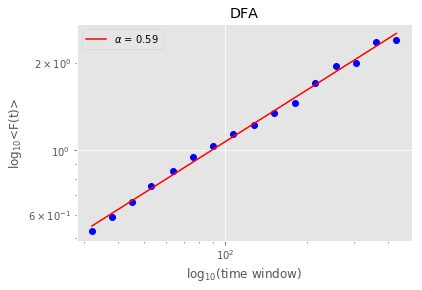

DFA exponent 0.5872209224746825


In [30]:
n = 2**12
dfa_alpha = 0.7
x = power_law_noise(n, dfa_alpha)
scales, fluct, esta = dfa(x, show=1)
print("DFA exponent {}".format(esta))

We got acceptable estimation of the initial value of $\alpha$=0.7.

### Simulation 1: artifacts

Now we are ready to perform the first simulation. In biomedical signals (EEG in particular) many high amplitude artifacts appear. Those can be caused by body movements, eyes blinking or just by recording device. Typically, in most of the studies researchers inspect signals visually and remove parts of them when neccessary. Although some more sophisticated methods exist, this is still the most common choice giving the best efficiency. However, because DFA is considered to be valid also for non-stationary time series we could take an adventage of that property. Beforehand let's test it if it is true.

First of all, we need some model of signal artifacs.

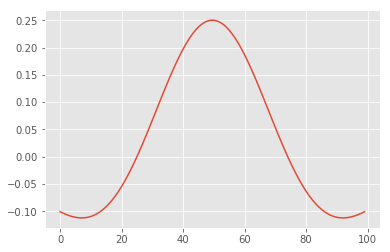

In [31]:
mr = ss.morlet(100, w=0.9, s=0.3)
plt.plot(mr.real)

Artifacts look very often as a big unexpected peak with much higher amplitude than the rest of the signal. I decided to model it as a Morlet wavelet with low frequency. I multiply part of the signal by that shape with some arbitrarly big amplitude.

The picture below shows an example of signal with artifact. 

DFA exponent 0.7165335312403098


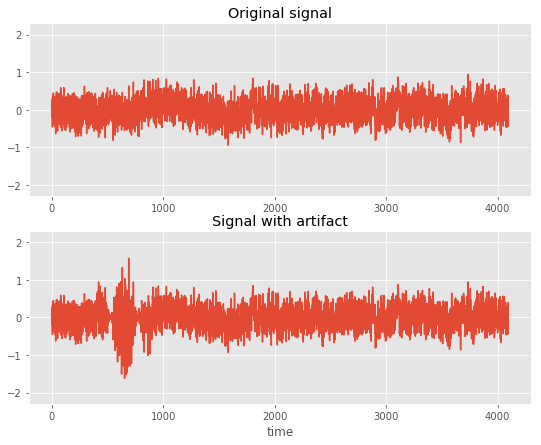

In [32]:
x = power_law_noise(n, dfa_alpha)
plt.figure(figsize=(9,7))
plt.subplot(211)
plt.plot(x)
plt.title("Original signal")
plt.ylim([-2.3,2.3])
ncut = 500
idx = 400
mr = ss.morlet(ncut, w=1, s=0.3)
x[idx:idx+ncut] *= 10*mr.real
plt.subplot(212)
plt.plot(x)
plt.ylim([-2.3,2.3])
plt.xlabel('time')
plt.title("Signal with artifact")
scales, fluct, esta = dfa(x)
print("DFA exponent {}".format(esta))

Now we perform bootstrapping, so in principle repeat such an operation *Nrep* times adding artifacts in random places with random amplitudes and lengths.

In [33]:
Nrep = 1000                   # how many resamplings
x_down, x_top = 400, 3500     # range of artifacts beginnings
sig_amp, mu_amp = 3.5, 10     # amplitude parameters (to random Gauss generator)
sig_ncut, mu_ncut = 100, 500  # length of the artifact

dfavec = np.zeros(Nrep)
for i in range(Nrep):
    if i%10==0: print(i, end=' ')
    x = power_law_noise(n, dfa_alpha)
    idx = np.random.randint(x_down, x_top)
    ncut = int(np.random.randn()*sig_ncut+mu_ncut)
    mr = ss.morlet(ncut, w=np.random.randn()*0.1+1, s=np.random.randn()*0.1+0.3)
    amp = np.random.randn()*sig_amp+mu_amp
    if idx+ncut-x.shape[0] > 0: idx = x.shape[0]-ncut-1 # checks if idxs are in range of x
    x[idx:idx+ncut] *= amp*mr.real
    scales, fluct, estalpha = dfa(x)
    dfavec[i] = estalpha

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 

As a result we get a histogram with confidence level values marked by red dashed lines and actual value marked as a purple line. We see that we cannot reject a null-hypothesis that artifacts (those generated as above) don't have any impact on DFA exponent estimation.

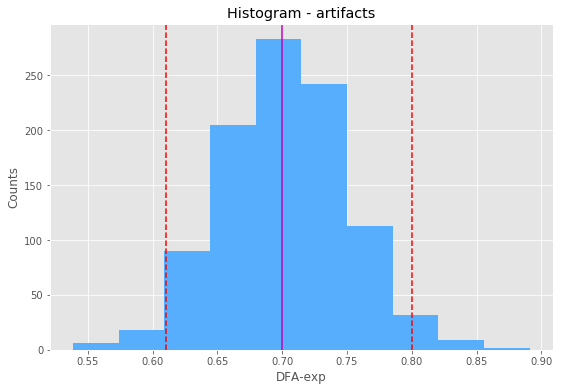

In [34]:
alpha = 0.05
v1 = st.scoreatpercentile(dfavec, 0.5*alpha*100)
v2 = st.scoreatpercentile(dfavec, 100-0.5*alpha*100)
plt.figure(figsize=(9,6))
plt.hist(dfavec, color='#57aefc')
plt.axvline(v1, color='r', linestyle='--')
plt.axvline(v2, color='r', linestyle='--')
plt.axvline(dfa_alpha, color='m')
plt.ylabel('Counts')
plt.xlabel('DFA-exp')
plt.title('Histogram - artifacts')
plt.show()

### Simulation 2: slicing

In the second simulation we are going to check what happens if we slice the signal and join two pieces together. Does it affect DFA value?

As it happened before firstly we consider only signle case.

DFA exponent 0.733711151378798


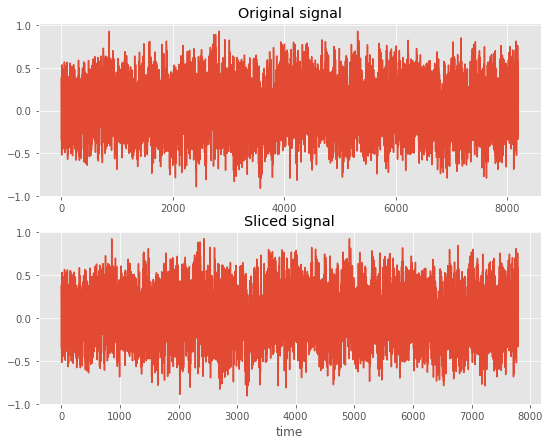

In [35]:
n = 2**13
x = power_law_noise(n, dfa_alpha)
plt.figure(figsize=(9,7))
plt.subplot(211)
plt.plot(x)
plt.title("Original signal")
plt.subplot(212)
idx = 1400
gap_width = 400
x_c = np.concatenate((x[:idx],x[idx+gap_width:]))
plt.plot(x_c)
plt.xlabel('time')
plt.title("Sliced signal")
scales, fluct, estaalpha = dfa(x_c)
print("DFA exponent {}".format(estaalpha))

And now we test it by bootstrapping.

In [36]:
Nrep = 1000                            # how many resamplings
x_down, x_top = int(0.1*n), int(0.9*n) # range of slice
sig_gw, mu_gw = 100, 300               # gap width

gap_width = 200

dfavec = np.zeros(Nrep)
for i in range(Nrep):
    if i%10==0: print(i, end=" ")
    x = power_law_noise(n, dfa_alpha)
    idx = np.random.randint(x_down, x_top)
    gap_width = int(np.random.randn()*sig_gw+mu_gw)
    x_c = np.concatenate((x[:idx],x[idx+gap_width:]))
    scales, fluct, estalpha = dfa(x)
    dfavec[i] = estalpha

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 

Once again the initial value is in between confidence intervals so we can infer that slicing has no effect on DFA estimation.

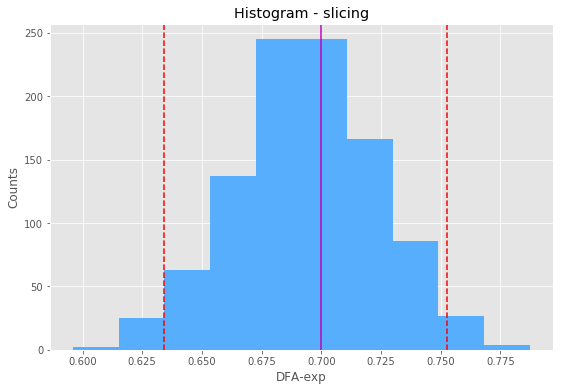

In [37]:
alpha = 0.05
v1 = st.scoreatpercentile(dfavec, 0.5*alpha*100)
v2 = st.scoreatpercentile(dfavec, 100-0.5*alpha*100)
plt.figure(figsize=(9, 6))
plt.hist(dfavec, color='#57aefc')
plt.axvline(v1, color='r', linestyle='--')
plt.axvline(v2, color='r', linestyle='--')
plt.axvline(dfa_alpha, color='m')
plt.ylabel('Counts')
plt.xlabel('DFA-exp')
plt.title('Histogram - slicing')
plt.show()